In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
import os

os.environ["LANGCHAIN_API_KEY"] = os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_PROJECT"] = os.getenv("LANGCHAIN_PROJECT")
os.environ["LANGCHAIN_TRACING_V2"] = "true"

In [3]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(
    model_name="gpt-4o"
)

In [4]:
from pydantic import BaseModel, Field
from typing import Optional, List, Dict, Any

class TravelAgentState(BaseModel):
    user_query: Optional[List[str]] = Field(default=None, description="User query and any follow-up questions")
    current_place: Optional[str] = Field(default=None, description="Current place of the user")
    destination: Optional[str] = Field(default=None, description="Destination the user wants to go")
    start_date: Optional[str] = Field(default=None, description="Start date of the trip")
    end_date: Optional[str] = Field(default=None, description="End date of the trip")
    num_days: Optional[int] = Field(default=None, description="Number of days of the trip")
    native_currency: Optional[str] = Field(default=None, description="Native currency of the user")
    budget_range: Optional[str] = Field(default=None, description="Budget range of the trip")
    interests: Optional[List[str]] = Field(default=None, description="Interests such as activities, attractions, restaurants, transportation of the user")

    current_weather: Optional[Dict[str, Any]] = Field(default=None, description="Current weather of the destination")
    weather_forecast: Optional[List[Dict[str, Any]]] = Field(default=None, description="Weather forecast of the destination")

    attractions: Optional[List[Dict[str, Any]]] = Field(default=None, description="Attractions of the destination")
    activities: Optional[List[Dict[str, Any]]] = Field(default=None, description="Activities of the destination")
    restaurants: Optional[List[Dict[str, Any]]] = Field(default=None, description="Restaurants of the destination")
    transportation_info: Optional[Dict[str, Any]] = Field(default=None, description="Transportation information of the destination")

    hotel_options: Optional[List[Dict[str, Any]]] = Field(default=None, description="Hotel options of the destination")
    hotel_cost_per_day: Optional[float] = Field(default=None, description="Hotel cost per day of the destination")
    total_hotel_cost: Optional[float] = Field(default=None, description="Total hotel cost of the destination")

    exchange_rate: Optional[float] = Field(default=None, description="Exchange rate of the destination")
    converted_hotel_cost: Optional[float] = Field(default=None, description="Converted hotel cost of the destination")
    total_trip_cost: Optional[float] = Field(default=None, description="Total trip cost of the destination")
    daily_budget: Optional[float] = Field(default=None, description="Daily budget of the destination")

    daily_plans: Optional[List[str]] = Field(default=None, description="Daily plans of the destination")
    full_itinerary: Optional[str] = Field(default=None, description="Full itinerary of the destination")

    summary: Optional[str] = Field(default=None, description="Summary of the destination")
    travel_plan_output: Optional[Dict[str, Any]] = Field(default=None, description="Travel plan output of the destination")

    validation_errors: Optional[List[str]] = Field(default=None, description="Validation errors of the destination")

In [5]:
class UserQuery(BaseModel):
    current_place: Optional[str] = Field(description="Current place of the user")
    destination: Optional[str] = Field(description="Destination the user wants to go")
    start_date: Optional[str] = Field(description="Start date of the trip")
    end_date: Optional[str] = Field(description="End date of the trip")
    num_days: Optional[int] = Field(description="Number of days of the trip")
    interests: Optional[List[str]] = Field(description="Interests of the user")
    native_currency: Optional[str] = Field(description="Native currency of the user")
    budget_range: Optional[str] = Field(description="Budget range of the trip") 

In [6]:
from langchain_core.output_parsers import JsonOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from datetime import datetime

def parse_user_query(state: TravelAgentState) -> TravelAgentState:
    json_output_parser = JsonOutputParser(pydantic_object=UserQuery)
    format_instructions = json_output_parser.get_format_instructions()

    prompt = PromptTemplate(
        template="""
        You are an intelligent travel agent assistant. Extract and intelligently infer the following fields from the user query.

        Current Date = {current_date}
        
        SMART EXTRACTION RULES:
        1. **Current Place (MUST BE CITY)**:
           - Always extract/convert to a specific city name
           - If country/region given, convert to major city (USA→"New York", UK→"London", France→"Paris")
           - If unclear which city, set to `null` for follow-up

        2. **Destination (FLEXIBLE)**:
           - Can be country, region, or city ("France", "Paris", "Europe", "Tokyo")
           - Keep as user specified - don't force conversion to city

        3. **Currency Intelligence**:
           - Auto-detect from current_place city/country
           - London→GBP, Paris→EUR, New York→USD, Tokyo→JPY, Mumbai→INR

        4. **Interest Intelligence**:
           - Infer from context: "sightseeing"→["attractions"], "food tour"→["restaurants","food"]
           - "museums"→["culture","museums"], "beaches"→["beaches","relaxation"]

        5. **Date & Budget Intelligence**:
           - Parse dates to YYYY-MM-DD format
           - If start_date and num_days provided, calculate end_date automatically
           - Extract budget hints: "cheap"→"budget", "$1000"→"$1000"

        EXAMPLES:
        "I'm in London, want to visit France" → current_place: "London", destination: "France", native_currency: "GBP"
        "From California to Japan" → current_place: "Los Angeles", destination: "Japan", native_currency: "USD"
        "From India, going to Europe" → current_place: null (unclear city), destination: "Europe", native_currency: null

        User Query: {query}

        Return a valid JSON object with the format:
        {format_instructions}
        """,
        input_variables=["query"],
        partial_variables={
            "format_instructions": format_instructions, 
            "current_date": datetime.now().strftime("%Y-%m-%d")
        }
    )

    llm_parser = ChatOpenAI(model="gpt-4o", temperature=0)
    chain = prompt | llm_parser | json_output_parser

    latest_query = state.user_query[-1] if state.user_query else ""
    parsed = chain.invoke(latest_query)

    if parsed.get("current_place"):
        state.current_place = parsed.get("current_place")
    if parsed.get("destination"):
        state.destination = parsed.get("destination")
    if parsed.get("start_date"):
        state.start_date = parsed.get("start_date")
    if parsed.get("end_date"):
        state.end_date = parsed.get("end_date")
    if parsed.get("num_days"):
        state.num_days = parsed.get("num_days")
    if parsed.get("budget_range"):
        state.budget_range = parsed.get("budget_range")
    if parsed.get("interests"):
        state.interests = parsed.get("interests")
    if parsed.get("native_currency"):
        state.native_currency = parsed.get("native_currency")

    return state

In [7]:
def generate_follow_up_question(validation_errors: list, state: TravelAgentState) -> str:
    known_info = []
    if state.destination:
        known_info.append(f"going to {state.destination}")
    if state.start_date:
        known_info.append(f"starting {state.start_date}")
    if state.end_date:
        known_info.append(f"ending {state.end_date}")
    if state.num_days:
        known_info.append(f"for {state.num_days} days")
    
    context = " and ".join(known_info) if known_info else "planning a trip"
    
    prompt = PromptTemplate(
        template="""
        You are a friendly travel agent assistant helping a user plan their trip. 
        
        CONTEXT: The user is {context}.
        MISSING INFORMATION: {missing_fields}
        
        Generate a single, natural, conversational follow-up question to get the MOST IMPORTANT missing information.
        
        GUIDELINES:
        1. Ask for only ONE piece of information at a time
        2. Be conversational and friendly
        3. Provide examples when helpful
        4. Prioritize in this order: current city → destination → dates → budget → currency → interests
        5. For current city, emphasize it should be a specific city name
        6. Keep it concise and natural
        
        EXAMPLES:
        - "Which city are you traveling from? (e.g., London, New York, Mumbai)"
        - "What's your budget range for this trip? (e.g., $1000-2000, budget-friendly, luxury)"
        - "What are you most interested in during your trip? (e.g., museums, food, beaches, nightlife)"
        
        Generate only the question, no extra text:
        """,
        input_variables=["context", "missing_fields"]
    )
    
    llm_question = ChatOpenAI(model="gpt-4o", temperature=0.3)
    chain = prompt | llm_question
    
    missing_fields_text = ", ".join(validation_errors)
    response = chain.invoke({
        "context": context,
        "missing_fields": missing_fields_text
    })
    
    return response.content.strip()

In [8]:
def validate_and_collect(state: TravelAgentState) -> TravelAgentState:
    while True:
        # Check what's missing
        errors = []
        if state.current_place is None:
            errors.append("Current place is required")
        if state.destination is None:
            errors.append("Destination is required")
        if state.start_date is None:
            errors.append("Start date is required")
        if state.end_date is None:
            errors.append("End date is required")
        if state.num_days is None:
            errors.append("Number of days is required")
        if state.native_currency is None:
            errors.append("Native currency is required")
        if state.budget_range is None:
            errors.append("Budget range is required")
        if state.interests is None:
            errors.append("Interests are required")

        state.validation_errors = errors
        
        # If no errors, we're done
        if not errors:
            print("✅ All information collected successfully!")
            break
            
        # Ask for missing info
        follow_up_question = generate_follow_up_question(errors, state)
        print(f"\nAssistant: {follow_up_question}")
        
        follow_up = input("You: ")
        
        if not follow_up.strip():
            state.validation_errors = ["EXIT"]
            print("Collection ended by user.")
            break
            
        # Add response and parse
        state.user_query = (state.user_query or []) + [follow_up]
        state = parse_user_query(state)
    
    return state

In [9]:
def parse_user_query_node(state: TravelAgentState) -> TravelAgentState:
    print(">>> Parsing input")
    return parse_user_query(state)

def validate_and_collect_node(state: TravelAgentState) -> TravelAgentState:
    print(">>> Validating and collecting missing information")
    return validate_and_collect(state)

In [21]:
from langgraph.graph import StateGraph, END

def check_if_complete(state: TravelAgentState):
    if state.validation_errors and "EXIT" in state.validation_errors:
        return END
    return END

builder = StateGraph(TravelAgentState)
builder.add_node("parse_user_input", parse_user_query_node)
builder.add_node("validate_and_collect", validate_and_collect_node)

builder.set_entry_point("parse_user_input")
builder.add_edge("parse_user_input", "validate_and_collect")
builder.add_conditional_edges("validate_and_collect", check_if_complete)

graph = builder.compile()

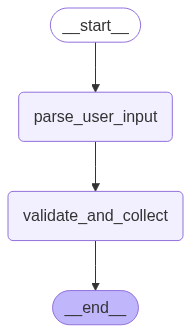

In [22]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
state = TravelAgentState(user_query=["I want to go to Paris from tomorrow. I want to stay at hotel and eat at restaurants. I want to visit Eiffel Tower and Louvre Museum. My budget is 2 Lakhs."])
final_state = graph.invoke(state)

>>> Parsing input
>>> Validating and collecting missing information

Assistant: "Which city are you traveling from? (e.g., London, New York, Mumbai)"

Assistant: How many days are you planning to stay in Paris?
✅ All information collected successfully!


In [20]:
print(final_state)

{'user_query': ['I want to go to Paris from tomorrow. I want to stay at hotel and eat at restaurants. I want to visit Eiffel Tower and Louvre Museum. My budget is 2 Lakhs.', 'DELHI', '6 days'], 'current_place': 'New Delhi', 'destination': 'Paris', 'start_date': '2025-06-15', 'end_date': '2025-06-21', 'num_days': 6, 'native_currency': 'INR', 'budget_range': '2 Lakhs', 'interests': ['attractions', 'restaurants', 'culture', 'museums'], 'validation_errors': []}
